<a href="https://colab.research.google.com/github/damikag/drivendata-pumpitup-competition/blob/main/Pre_Processing_and_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/)

> HOSTED BY DRIVENDATA


---

In [1]:
  from google.colab import drive
drive.mount('/content/drive')

!cp -a 'drive/My Drive/UNI/Semester 7/Machine Learning/Assignments/DrivenData/inputs' .
!ls 'drive/My Drive/UNI/Semester 7/Machine Learning/Assignments/DrivenData/inputs'

Mounted at /content/drive
'Test set values.csv'  'Train set labels.csv'  'Train set values.csv'


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

import warnings; warnings.simplefilter('ignore')

# Data Pre-Processing


In [3]:
df_train_set_labels = pd.read_csv('inputs/Train set labels.csv')
df_train_set_values = pd.read_csv('inputs/Train set values.csv')
df_test = pd.read_csv('inputs/Test set values.csv')

In [4]:
df_train = df_train_set_values.merge(df_train_set_labels,on='id',how='left')
df_combined = pd.concat([df_train_set_values,df_test])

In [5]:
df_features = pd.DataFrame(df_train[['id', 'amount_tsh', 'population', 'gps_height', 'latitude', 'longitude']])
df_features = df_features.merge(df_train_set_labels,on='id',how='left')

### Outlier Handling

Latitudes and Longitudes

In [6]:
# Longitudes
df_train['longitude'] = df_train['longitude'].replace(0,np.nan)
df_train['avglongitude'] = df_train.groupby('region')['longitude'].transform('mean')
df_train['longitude'] = df_train['longitude'].fillna(df_train["avglongitude"])
df_features['longitude'] = df_train['longitude']

# Latitudes
df_train['latitude'] = df_train['latitude'].replace(0,np.nan)
df_train['avglatitude'] = df_train.groupby('region')['latitude'].transform('mean')
df_train['latitude'] = df_train['latitude'].fillna(df_train["avglatitude"])
df_features['latitude'] = df_train['latitude']


Amount_tsh, Population, and GPS Height

Values outside of the range (q1 - 1.5 x IQR, q3 + 1.5 x IQR) are considered as outliers and replaced with the median of the distribution

In [7]:
def median_impute(df, colum_name):
  q1 = df[colum_name].quantile(0.25)
  q3 = df[colum_name].quantile(0.75)
  iqr = q3-q1
  lower = q1 - iqr*1.5
  upper = q3 + iqr*1.5

  print(colum_name,lower,upper)

  median = df[colum_name].median()

  return df[colum_name].apply(lambda x: median if (x<lower or x>upper) else x)


In [8]:
df_features['amount_tsh'] = median_impute(df_features, 'amount_tsh')
df_features['population'] = median_impute(df_features, 'population')
df_train['gps_height'] = median_impute(df_train, 'gps_height')


amount_tsh -30.0 50.0
population -322.5 537.5
gps_height -1978.875 3298.125


gps_height has zeros that looks deviated from the distribution and appears to be outliers. They were replaced with the mean of the respective ward(a geographical area).

In [9]:
df_train['gps_height'] = df_train['gps_height'].apply(lambda x: np.nan if x<=0 else x)
df_train['avg_height'] = df_train.groupby('ward')['gps_height'].transform(lambda x: x.gt(0).mean())
df_train['gps_height'] = df_train['gps_height'].fillna(df_train["avg_height"])
df_features['gps_height'] = df_train['gps_height']

##### Contruction Year
Some rows contains zeros. Those are replaced with the mean of entries greater than zero.

In [10]:
construction_year_mean = df_train['construction_year'].sum()//(df_train['construction_year'].loc[df_train['construction_year'].gt(0)].count())
df_train['construction_year'] = df_train['construction_year'].apply(lambda x: construction_year_mean if x==0 else x)

### Feature Standardization

amount_tsh, population and gps_height are standardized.

In [11]:
mean_amount_tsh = df_features['amount_tsh'].mean()
std_amount_tsh = df_features['amount_tsh'].std()
df_features['amount_tsh'] = df_features['amount_tsh'].apply(lambda x: (x-mean_amount_tsh)/std_amount_tsh)

mean_population = df_features['population'].mean()
std_population = df_features['population'].std()
df_features['population'] = df_features['population'].apply(lambda x: (x-mean_population)/std_population)

mean_gps_height = df_features['gps_height'].mean()
std_gps_height = df_features['gps_height'].std()
df_features['gps_height'] = df_features['gps_height'].apply(lambda x: (x-mean_gps_height)/std_gps_height)

### Creating New Features

Age_at_year_recorded = construction_year - recorded_year

In [12]:
df_features['Age_at_year_recorded'] = pd.to_datetime(df_train['date_recorded']).dt.year-df_train['construction_year']

### Missing Value Handling

In [13]:
def PP_impute_with_medianormode (df):

    num_cols = df._get_numeric_data().columns
    categorical_columns=list(set(df.columns) - set(num_cols))
    print("categorical_columns are",categorical_columns)
      
    # Get list of DataFrame column names
    cols = list(df)
    # Loop through columns
    for column in cols:
      # Transfer column to independent series
      col_data = df[column]
      # Look to see if there is any missing numerical data
      
      missing_data = sum(col_data.isna())

      if missing_data > 0:

          if (column in categorical_columns): #For categorical columns replace with mode
              #col_mode=col_data.mode()
              col_mode=col_data.value_counts().index[0]
              print("Categorical column is '%s' and its mode is '%s'"%(column,col_mode))
          
              col_data.fillna(col_mode, inplace=True)
              #col_data.replace('NaN',col_mode,inplace=True)
              df[column] = col_data
          else:
              # Get median and replace missing numerical data with median
              col_median = col_data.median()
              print("Numerical column is '%s' and its median is '%s'"%(column,col_median))
              col_data.fillna(col_median, inplace=True)
              df[column] = col_data
    return df

In [14]:
df_train['permit'] = PP_impute_with_medianormode(df_train[['permit']])
df_train['public_meeting'] = PP_impute_with_medianormode(df_train[['public_meeting']])

categorical_columns are ['permit']
Categorical column is 'permit' and its mode is 'True'
categorical_columns are ['public_meeting']
Categorical column is 'public_meeting' and its mode is 'True'


### Label Encoding / One-hot Encoding Features

In [15]:
enc_basin = LabelEncoder()
df_features['basin'] = enc_basin.fit_transform(df_train['basin'].astype(str))

# enc_1hot_basin = OneHotEncoder(handle_unknown='ignore')
# df_features = df_features.join(pd.DataFrame(enc_1hot_basin.fit_transform(df_train[['basin']]).toarray()).add_prefix("basin_"))

In [16]:
# enc_permit = LabelEncoder()
# df_train['permit'] = enc_permit.fit_transform(df_train['permit'].fillna(df_train['permit'].mode()))

enc_1hot_permit = OneHotEncoder(handle_unknown='ignore')
df_features = df_features.join(pd.DataFrame(enc_1hot_permit.fit_transform(df_train[['permit']]).toarray()).add_prefix("permit_"))

In [17]:
enc_extraction_type_class = LabelEncoder()
df_features['extraction_type_class'] = enc_extraction_type_class.fit_transform(df_train['extraction_type_class'].fillna(df_train['extraction_type_class'].mode()))


In [18]:
enc_management = LabelEncoder()
df_features['management'] = enc_management.fit_transform(df_train['management'].fillna('unknown'))

# enc_1hot_management = OneHotEncoder(handle_unknown='ignore')
# df_features = df_features.join(pd.DataFrame(enc_1hot_management.fit_transform(df_train[['management']]).toarray()).add_prefix("management_"))

In [19]:
enc_management_group = LabelEncoder()
df_features['management_group'] = enc_management_group.fit_transform(df_train['management_group'].fillna('unknown'))

In [20]:
# enc_water_quality = LabelEncoder()
# df_train['water_quality'] = enc_water_quality.fit_transform(df_train['water_quality'].fillna('unknown')

In [21]:
enc_quality_group = LabelEncoder()
df_features['quality_group'] = enc_quality_group.fit_transform(df_train['quality_group'].fillna('unknown'))

# enc_1hot_quality_group = OneHotEncoder(handle_unknown='ignore')
# df_features = df_features.join(pd.DataFrame(enc_1hot_quality_group.fit_transform(df_train[['quality_group']]).toarray()).add_prefix("quality_group_"))

In [22]:
# enc_quantity = LabelEncoder()
# df_train['quantity'] = enc_quantity.fit_transform(df_train['quantity'].fillna('unknown'))

enc_1hot_quantity = OneHotEncoder(handle_unknown='ignore')
df_features = df_features.join(pd.DataFrame(enc_1hot_quantity.fit_transform(df_train[['quantity']]).toarray()).add_prefix("quantity_"))

In [23]:
# enc_source = LabelEncoder()
# df_train['source'] = enc_source.fit_transform(df_train['source'].fillna('unknown'))

enc_1hot_source = OneHotEncoder(handle_unknown='ignore')
df_features = df_features.join(pd.DataFrame(enc_1hot_source.fit_transform(df_train[['source']]).toarray()).add_prefix("source_"))

In [24]:
# enc_waterpoint_type_group = LabelEncoder()
# df_train['waterpoint_type_group'] = enc_waterpoint_type_group.fit_transform(df_train['waterpoint_type_group'].fillna('other'))

enc_1hot_waterpoint_type_group = OneHotEncoder(handle_unknown='ignore')
df_features = df_features.join(pd.DataFrame(enc_1hot_waterpoint_type_group.fit_transform(df_train[['waterpoint_type_group']]).toarray()).add_prefix("waterpoint_type_group_"))

In [25]:
# enc_region_code = LabelEncoder()
# df_features['region_code'] = enc_region_code.fit_transform(df_train['region_code'].fillna('other'))


enc_1hot_region_code = OneHotEncoder(handle_unknown='ignore')
df_features = df_features.join(pd.DataFrame(enc_1hot_region_code.fit_transform(df_train[['region_code']]).toarray()).add_prefix("region_code_"))

In [26]:
enc_construction_year = LabelEncoder()
df_features['construction_year'] = enc_construction_year.fit_transform(df_train['construction_year'])

# enc_1hot_construction_year = OneHotEncoder(handle_unknown='ignore')
# df_features = df_features.join(pd.DataFrame(enc_1hot_construction_year.fit_transform(df_train[['construction_year']]).toarray()).add_prefix("construction_year_"))

In [27]:
enc_funder = LabelEncoder()
enc_funder.fit(df_combined['funder'].astype(str))
df_features['funder'] = enc_funder.transform(df_train['funder'].astype(str))

# df_train['funder'] = PP_impute_with_medianormode(df_train[['funder']])
# enc_1hot_funder = OneHotEncoder(handle_unknown='ignore')
# df_features = df_features.join(pd.DataFrame(enc_1hot_funder.fit_transform(df_train[['funder']]).toarray()).add_prefix("funder_"))

In [28]:
enc_installer = LabelEncoder()
enc_installer.fit(df_combined['installer'].astype(str))
df_features['installer'] = enc_installer.transform(df_train['installer'].astype(str))

In [29]:
# enc_subvillage = LabelEncoder()
# df_features['subvillage'] = enc_subvillage.fit_transform(df_train['subvillage'].astype(str))

In [30]:
enc_lga = LabelEncoder()
df_features['lga'] = enc_lga.fit_transform(df_train['lga'].astype(str))

In [31]:
enc_public_meeting = LabelEncoder()
df_features['public_meeting'] = enc_public_meeting.fit_transform(df_train['public_meeting'])

In [32]:
enc_payment = LabelEncoder()
df_features['payment'] = enc_payment.fit_transform(df_train['payment'])

In [33]:
enc_source_class = LabelEncoder()
df_features['source_class'] = enc_source_class.fit_transform(df_train['source_class'])

In [34]:
enc_waterpoint_type_group = LabelEncoder()
df_features['waterpoint_type_group'] = enc_waterpoint_type_group.fit_transform(df_train['waterpoint_type_group'])

In [35]:
df_features.head()

,id,amount_tsh,population,gps_height,latitude,longitude,status_group,Age_at_year_recorded,basin,permit_0,permit_1,extraction_type_class,management,management_group,quality_group,quantity_0,quantity_1,quantity_2,quantity_3,quantity_4,source_0,source_1,source_2,source_3,source_4,source_5,source_6,source_7,source_8,source_9,waterpoint_type_group_0,waterpoint_type_group_1,waterpoint_type_group_2,waterpoint_type_group_3,waterpoint_type_group_4,waterpoint_type_group_5,region_code_0,region_code_1,region_code_2,region_code_3,region_code_4,region_code_5,region_code_6,region_code_7,region_code_8,region_code_9,region_code_10,region_code_11,region_code_12,region_code_13,region_code_14,region_code_15,region_code_16,region_code_17,region_code_18,region_code_19,region_code_20,region_code_21,region_code_22,region_code_23,region_code_24,region_code_25,region_code_26,construction_year,funder,installer,lga,public_meeting,payment,source_class,waterpoint_type_group
0,69572,-0.304223,0.137788,1.041262,-9.856322,34.938093,functional,12,1,1.0,0.0,0,7,4,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39,1548,1706,51,1,2,0,1
1,8776,-0.304223,1.418889,1.054256,-2.147466,34.698766,functional,3,4,0.0,1.0,0,11,4,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,522,610,103,1,0,1,1
2,34310,1.963536,1.194134,0.024812,-3.821329,37.460664,functional,4,5,0.0,1.0,0,7,4,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,49,924,2296,108,1,4,1,1
3,67743,-0.304223,-0.244295,-0.585924,-11.155298,38.486161,non functional,27,7,0.0,1.0,5,7,4,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26,1961,2078,87,1,0,0,1
4,19728,-0.304223,-0.678821,-0.965648,-1.825359,31.130847,functional,15,4,0.0,1.0,0,1,1,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,20,133,26,1,0,1,1


# Model Creation

In [36]:
X = df_features.copy()
y = X.pop("status_group")
X.pop('id')

0        69572
1         8776
2        34310
3        67743
4        19728
         ...  
59395    60739
59396    27263
59397    37057
59398    31282
59399    26348
Name: id, Length: 59400, dtype: int64

In [37]:
X_tmp = X

# Comment the relevent line based of the sumission or not

is_submission = True
# is_submission = False

if not is_submission:
  X_train, X_test, y_train, y_test = train_test_split(X_tmp, y,test_size=0.2, random_state=1, stratify=y)
else:
  X_train = X_tmp
  y_train = y

### Random Forest Classifier

In [38]:
model = RandomForestClassifier(n_estimators=1000, max_depth=21, random_state=1)
model.fit(X_train, y_train)

print("Train Accuracy: ",accuracy_score(model.predict(X_train), y_train))
if not is_submission:
  print("Test Accuracy: ",accuracy_score(model.predict(X_test), y_test))

Train Accuracy:  0.9408585858585858


### Feature Importance of the Model

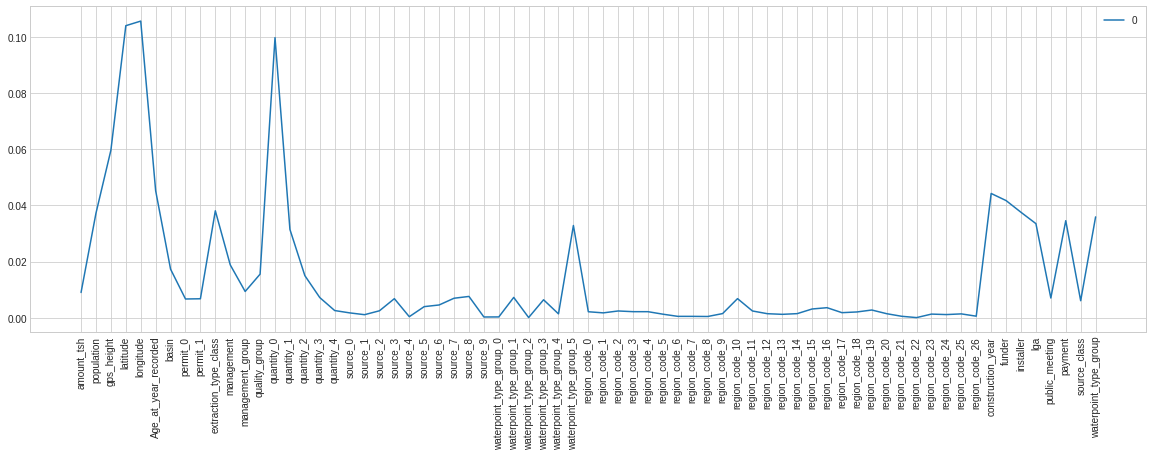

In [39]:
df_importance = pd.DataFrame(model.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(figsize=(20, 6))
fig.subplots_adjust(hspace=1.4)

sns.lineplot(data=df_importance)
for label in ax.get_xticklabels():
    label.set_rotation(90)

### Generating Submission

In [40]:
df_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


#### Pre-prosessing Test Set Values

In [41]:
df_features_test = pd.DataFrame(df_test[['id', 'amount_tsh', 'population', 'gps_height', 'latitude', 'longitude']])

df_features_test['amount_tsh'] = df_features_test['amount_tsh'].apply(lambda x: (x-mean_amount_tsh)/std_amount_tsh)
df_features_test['population'] = df_features_test['population'].apply(lambda x: (x-mean_population)/std_population)
df_features_test['gps_height'] = df_features_test['gps_height'].apply(lambda x: (x-mean_gps_height)/std_gps_height)

df_test['construction_year'] = df_test['construction_year'].apply(lambda x: construction_year_mean if x==0 else x)

In [42]:
df_features_test['Age_at_year_recorded'] = pd.to_datetime(df_test['date_recorded']).dt.year-df_test['construction_year']

In [43]:
df_test = df_test.merge(
    df_train[['region', 'avglongitude']].drop_duplicates(),
    on='region',
    how='left',
)
df_test['longitude'] = df_test['longitude'].replace(0,np.nan)
df_test['longitude'] = df_test['longitude'].fillna(df_test['avglongitude'])

df_features_test['longitude'] = df_test['longitude']

df_test = df_test.merge(
    df_train[['region', 'avglatitude']].drop_duplicates(),
    on='region',
    how='left',
)
df_test['latitude'] = df_test['latitude'].replace(0,np.nan)
df_test['latitude'] = df_test['latitude'].fillna(df_test['avglatitude'])

df_features_test['latitude'] = df_test['latitude']

In [44]:
# df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_basin.transform(df_test[['basin']]).toarray()).add_prefix("basin_"))
df_features_test['basin'] = enc_basin.transform(df_test['basin'].astype(str))

df_test['permit'] = PP_impute_with_medianormode(df_test[['permit']])
df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_permit.transform(df_test[['permit']]).toarray()).add_prefix("permit_"))

# df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_extraction_type.transform(df_test[['extraction_type']]).toarray()).add_prefix("extraction_type_"))
df_features_test['extraction_type_class'] = enc_extraction_type_class.transform(df_test['extraction_type_class'].fillna(df_test['extraction_type_class'].mode()))

df_features_test['management'] = enc_management.transform(df_test['management'].fillna('unknown'))
# df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_management.transform(df_test[['management']]).toarray()).add_prefix("management_"))

df_features_test['management_group'] = enc_management_group.transform(df_test['management_group'].fillna('unknown'))

df_features_test['quality_group'] = enc_quality_group.transform(df_test['quality_group'].fillna('unknown'))
# df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_quality_group.transform(df_test[['quality_group']]).toarray()).add_prefix("quality_group_"))

df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_quantity.transform(df_test[['quantity']]).toarray()).add_prefix("quantity_"))

df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_source.transform(df_test[['source']]).toarray()).add_prefix("source_"))

df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_waterpoint_type_group.transform(df_test[['waterpoint_type_group']]).toarray()).add_prefix("waterpoint_type_group_"))

df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_region_code.transform(df_test[['region_code']]).toarray()).add_prefix("region_code_"))

df_features_test['construction_year'] = enc_construction_year.transform(df_test['construction_year'])
# df_features_test = df_features_test.join(pd.DataFrame(enc_1hot_construction_year.transform(df_test[['construction_year']]).toarray()).add_prefix("construction_year_"))

df_features_test['funder'] = enc_funder.transform(df_test['funder'].astype(str))

df_features_test['installer'] = enc_installer.transform(df_test['installer'].astype(str))

df_features_test['lga'] = enc_lga.transform(df_test['lga'].astype(str))

df_test['public_meeting'] = PP_impute_with_medianormode(df_test[['public_meeting']])
df_features_test['public_meeting'] = enc_public_meeting.transform(df_test['public_meeting'])

df_features_test['payment'] = enc_payment.transform(df_test['payment'])

df_features_test['source_class'] = enc_source_class.transform(df_test['source_class'])

df_features_test['waterpoint_type_group'] = enc_waterpoint_type_group.transform(df_test['waterpoint_type_group'])

categorical_columns are ['permit']
Categorical column is 'permit' and its mode is 'True'
categorical_columns are ['public_meeting']
Categorical column is 'public_meeting' and its mode is 'True'


In [45]:
X_test_sub = df_features_test.copy()
X_test_sub.pop('id')

0        50785
1        51630
2        17168
3        45559
4        49871
         ...  
14845    39307
14846    18990
14847    28749
14848    33492
14849    68707
Name: id, Length: 14850, dtype: int64

In [46]:
X_test_sub.head()

,amount_tsh,population,gps_height,latitude,longitude,Age_at_year_recorded,basin,permit_0,permit_1,extraction_type_class,management,management_group,quality_group,quantity_0,quantity_1,quantity_2,quantity_3,quantity_4,source_0,source_1,source_2,source_3,source_4,source_5,source_6,source_7,source_8,source_9,waterpoint_type_group_0,waterpoint_type_group_1,waterpoint_type_group_2,waterpoint_type_group_3,waterpoint_type_group_4,waterpoint_type_group_5,region_code_0,region_code_1,region_code_2,region_code_3,region_code_4,region_code_5,region_code_6,region_code_7,region_code_8,region_code_9,region_code_10,region_code_11,region_code_12,region_code_13,region_code_14,region_code_15,region_code_16,region_code_17,region_code_18,region_code_19,region_code_20,region_code_21,region_code_22,region_code_23,region_code_24,region_code_25,region_code_26,construction_year,funder,installer,lga,public_meeting,payment,source_class,waterpoint_type_group
0,-0.304223,1.726053,1.916217,-4.059696,35.290799,1,0,0.0,1.0,3,3,2,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,52,345,426,63,1,0,1,5
1,-0.304223,1.568725,1.299706,-3.309214,36.656709,13,5,0.0,1.0,0,7,4,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,507,442,0,1,0,0,1
2,-0.304223,3.067089,1.296818,-5.004344,34.767863,3,0,0.0,1.0,3,7,4,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,2140,2372,109,1,0,1,5
3,-0.304223,1.194134,-0.580148,-9.418672,38.058046,26,7,0.0,1.0,3,7,4,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27,443,545,49,1,6,0,5
4,45.050949,-0.229311,0.853565,-10.950412,35.006123,13,7,0.0,1.0,0,9,4,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,150,164,61,1,3,0,1


#### Predicting and Write to Output File

In [47]:
Y_test_sub_predict = model.predict(X_test_sub)
df_test["status_group"] = Y_test_sub_predict

In [48]:
df_test[['id', 'status_group']].to_csv('out.csv',index = False)